## Notebook Cientifico de Datos
### Valentina Espitia
### Miguel García

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import re
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")

## Carga de las bases de datos

In [2]:
path = "D:/Downloads/PARCIAL IA/"

In [3]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
train = train.drop(columns = ["id"])
test = test.drop(columns = ["id"])
train.rename(columns = {"Mother's occupation": "Mother occupation",
                        "Father's occupation": "Father occupation",
                        "Mother's qualification": "Mother qualification",
                        "Father's qualification": "Father qualification"}, inplace = True)
test.rename(columns = {"Mother's occupation": "Mother occupation",
                        "Father's occupation": "Father occupation",
                        "Mother's qualification": "Mother qualification",
                        "Father's qualification": "Father qualification"}, inplace = True)

In [4]:
categ = ['Course','Marital status','Application mode', 'Application order', 'Daytime/evening attendance', 'Nacionality', 'Previous qualification'
        ,"Mother qualification","Father qualification", "Mother occupation", "Father occupation", 'Displaced', 'Educational special needs', 
         'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
for k in categ:
  train[k] = train[k].astype("O")
  test[k] = test[k].astype("O")

## Verificación de datos faltantes

In [5]:
faltantes_train = pd.DataFrame(train.isnull().sum()).reset_index()
faltantes_train.columns = ["Variable","Faltantes"]
faltantes_train["% Faltantes"] = faltantes_train["Faltantes"] * 100 / train.shape[0]
faltantes_train.loc[faltantes_train["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [6]:
formato_train = pd.DataFrame({'Variable': list(train.columns), 'Formato': train.dtypes })
ft_train = pd.merge(faltantes_train,formato_train,on=["Variable"],how="left")
ft_train.head()

,Variable,Faltantes,% Faltantes,Formato
0,Marital status,0,0.0,object
1,Application mode,0,0.0,object
2,Application order,0,0.0,object
3,Course,0,0.0,object
4,Daytime/evening attendance,0,0.0,object


In [7]:
faltantes_test = pd.DataFrame(test.isnull().sum()).reset_index()
faltantes_test.columns = ["Variable","Faltantes"]
faltantes_test["% Faltantes"] = faltantes_test["Faltantes"] * 100 / test.shape[0]
faltantes_test.loc[faltantes_test["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [8]:
formato_test = pd.DataFrame({'Variable': list(test.columns), 'Formato': test.dtypes })
ft_test = pd.merge(faltantes_test,formato_test,on=["Variable"],how="left")
ft_test.head()

,Variable,Faltantes,% Faltantes,Formato
0,Marital status,0,0.0,object
1,Application mode,0,0.0,object
2,Application order,0,0.0,object
3,Course,0,0.0,object
4,Daytime/evening attendance,0,0.0,object


## ANALISIS DESCRIPTIVO

In [9]:
cuantitativas = list(formato_train.loc[formato_train["Formato"]!="object","Variable"])
cuantitativas = [x for x in cuantitativas if x not in ["id","Target"]]

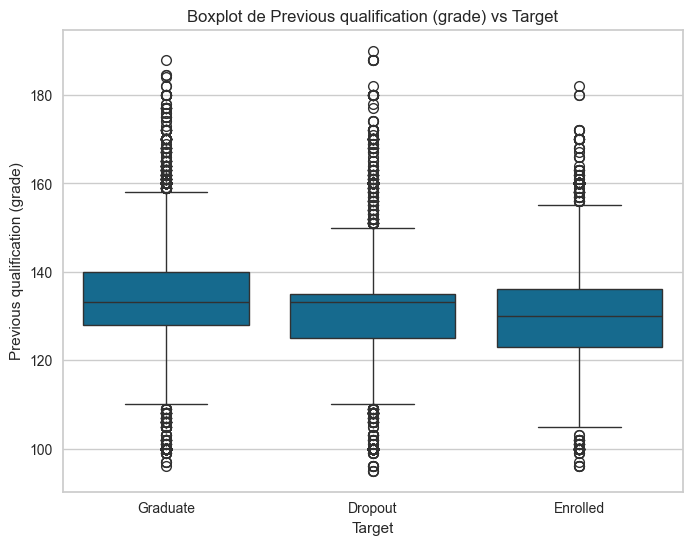

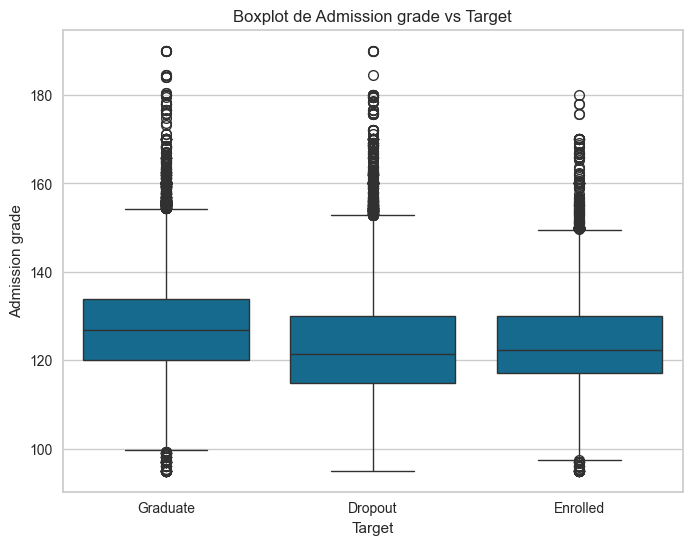

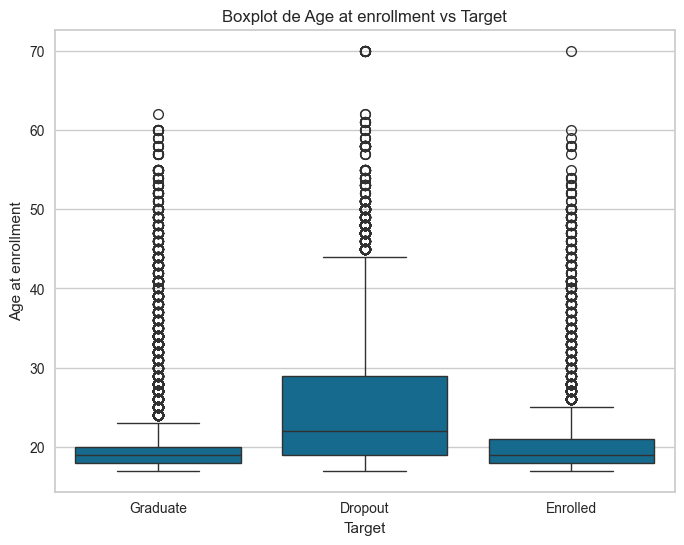

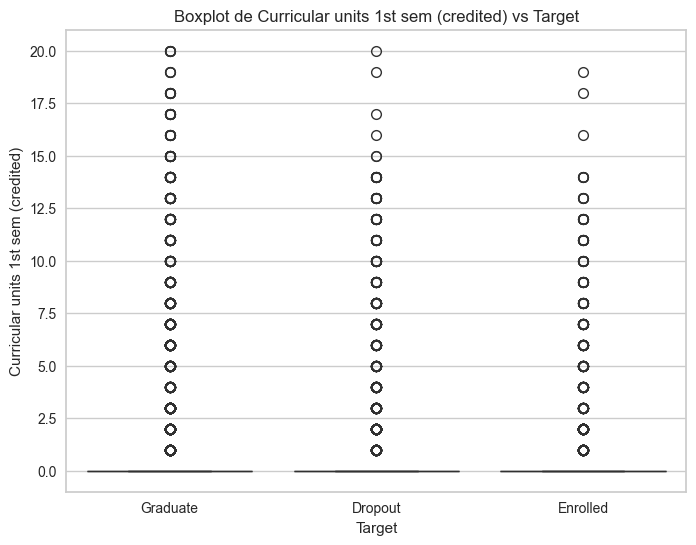

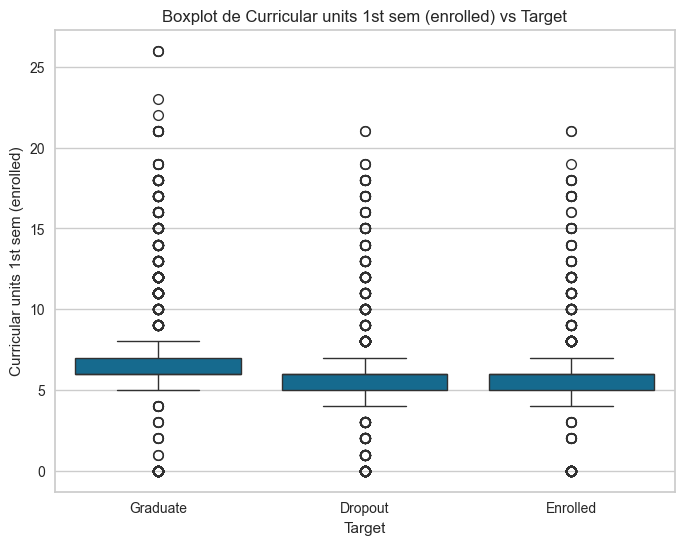

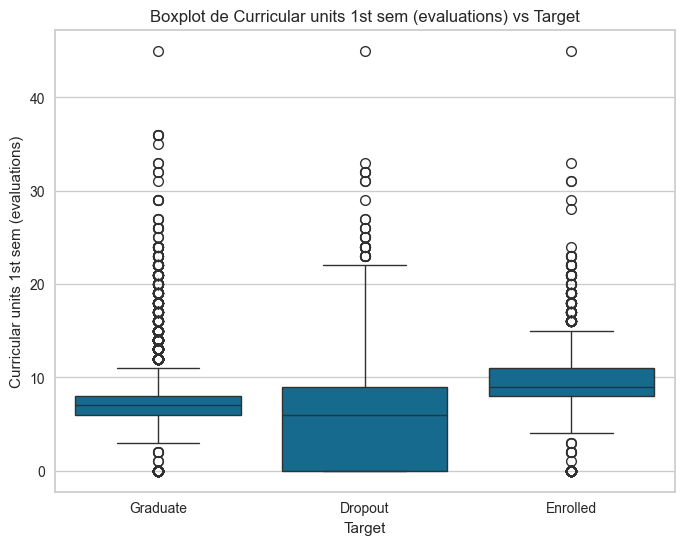

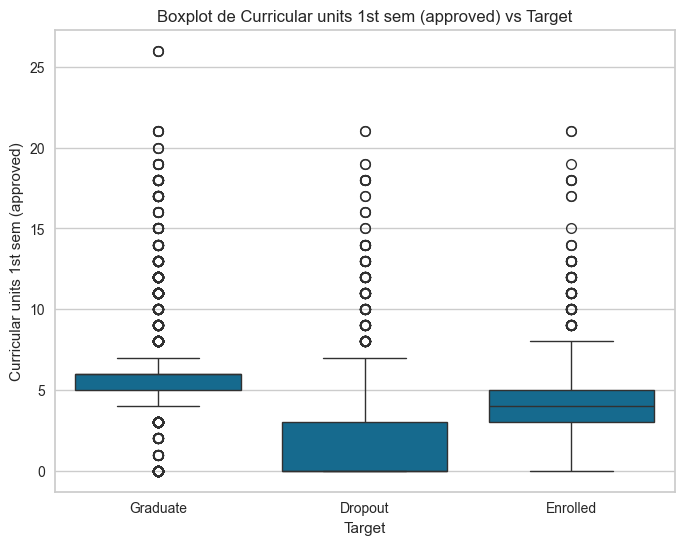

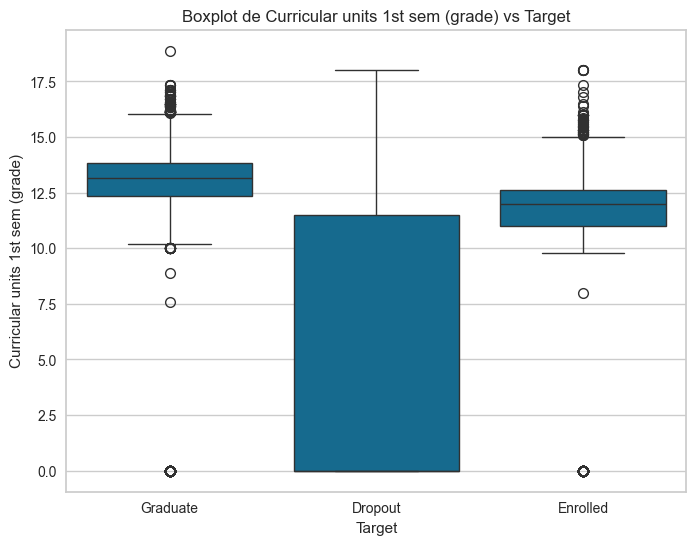

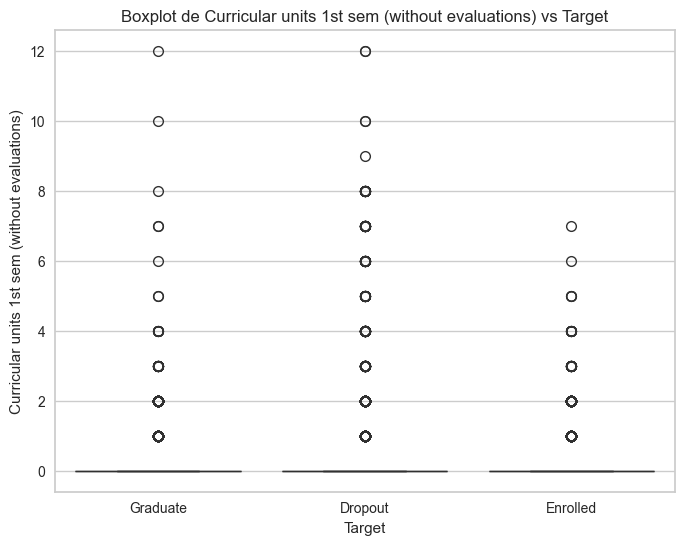

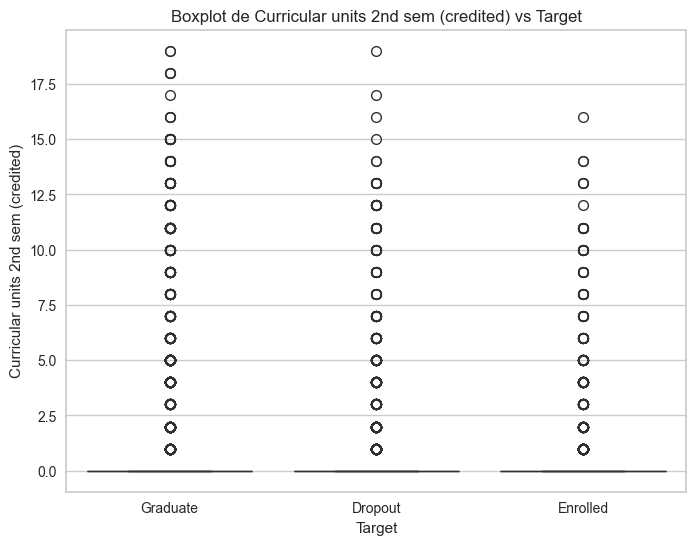

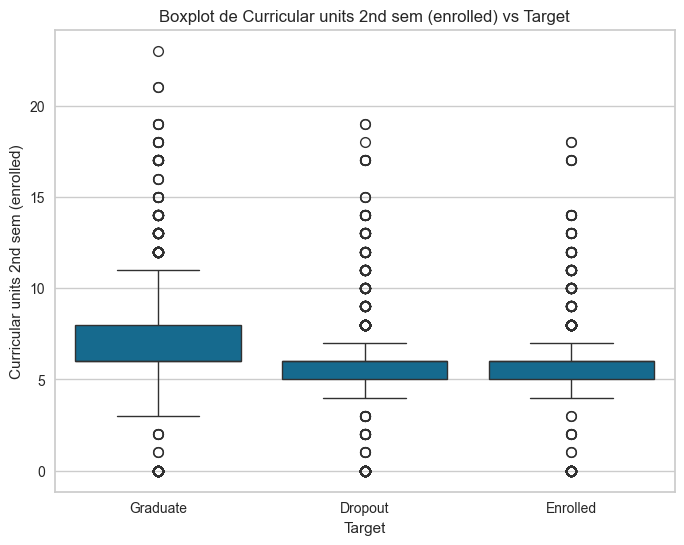

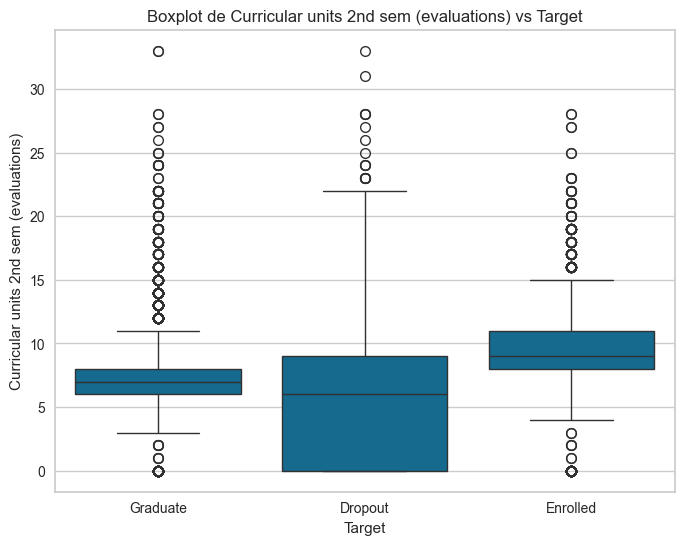

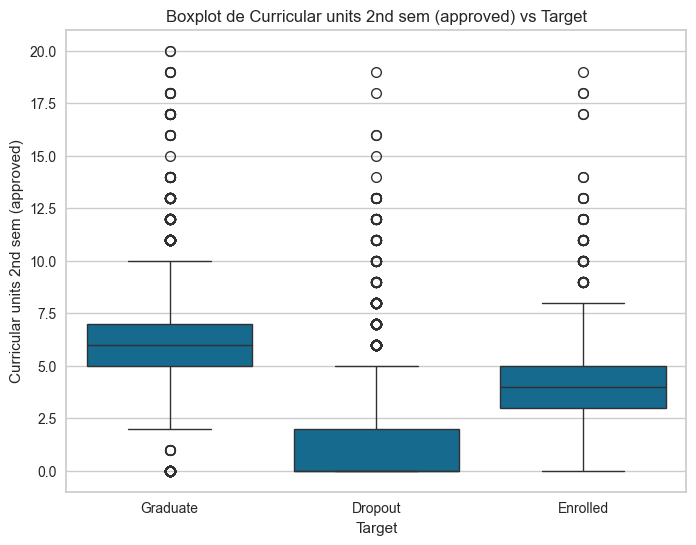

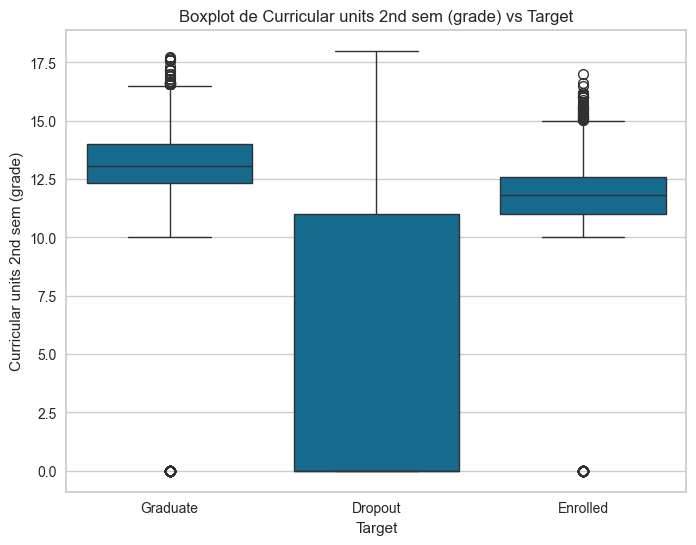

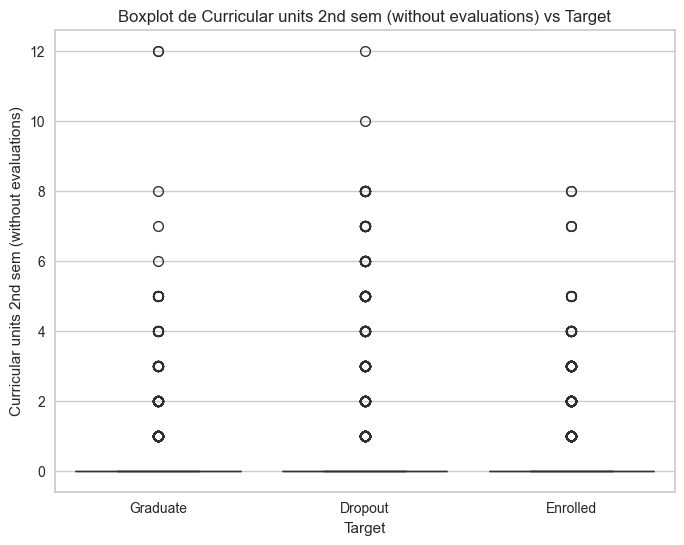

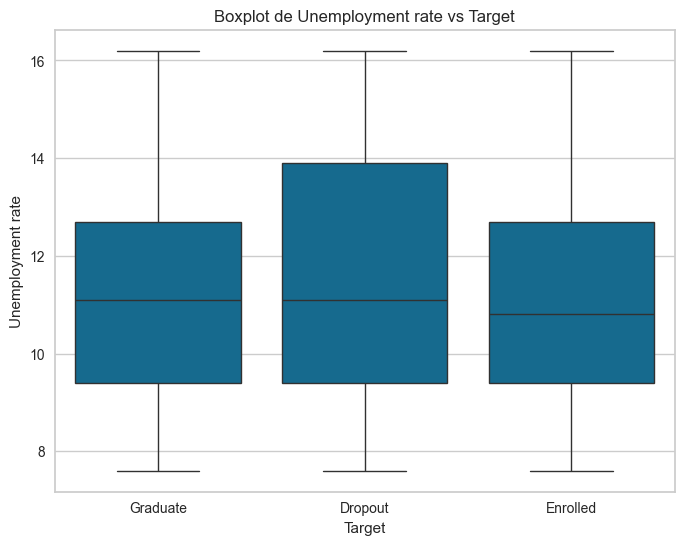

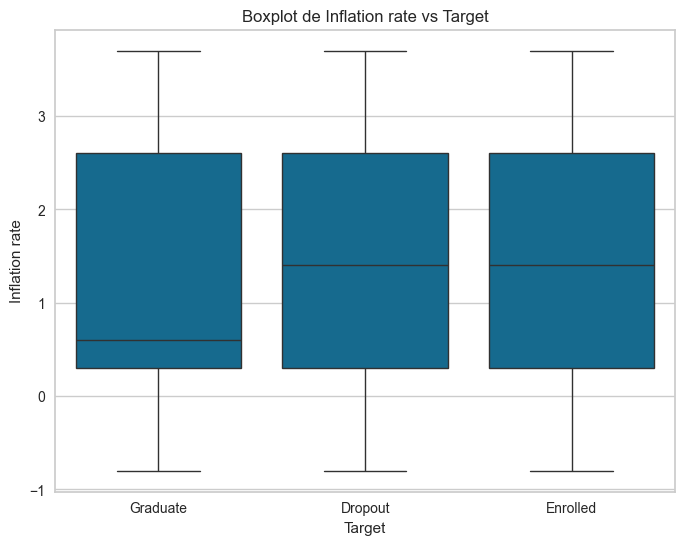

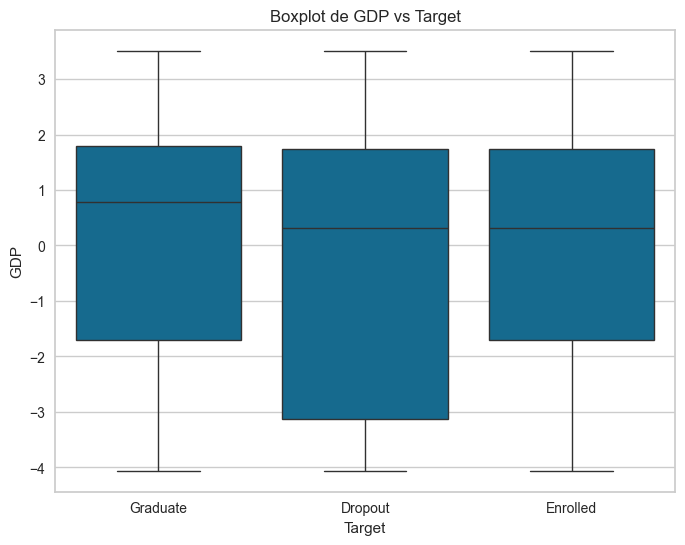

In [10]:
for k in cuantitativas:
    plt.figure(figsize=(8,6))
    sns.boxplot(x="Target",y=k,data=train)
    plt.title("Boxplot de "+k+" vs Target")

#### Observamos en el analisis descriptivo unos boxplot de todas las variables cuantitativas representadas en base a la variable respuesta que es Trget que se divide en -Graduado, -Abandonado, - Matriculado. 

#### - En el segundo boxplot de Previous qualification vs Target observamos una anomalia en los datos ya que la caja no tiene una visibilidad normal, alcontrario se observa una raya negra y muchos outliners hacia arriba y un poco dispersos lo que registra que hay muy pocos datos centrados y se presenta muy poca variabilidad.
#### - En el tercer boxplot de Previous qualification(grade) vs Target obtenemos una mediana entre 120 y 140 con una variabilidad un poco mas normal sin embargo, se presentan muchos datos fuera de la caja tanto en la parte superior como en la parte inferior. Ademas vemos que la mediana aumenta en las personas que se retiraron, le sigue los graduados y al final los matriculados
#### - En el cuarto boxplot de Mother's qualification vs Target obtenemos una mediana bastante parecida lo que indica que no se tienen muchas diferencias significativas, al contrario de el quinto boxplot de Father's qualification vs Target donde se evidencia una mediana muchisimo mas elevada en las personas que se retiraron que en el resto.
#### - En el sexto boxplot de Admission grade vs Target observamos una media significativamente alta en las personas graduadas y asi mismo los datos centrados hacia arriba.
#### - En el septimo boxplot de Age at enrollment vs Target observamos que los graduados tienen menos variabilidad en los datos al igual que los matriculados, en cambio los que desertaron se observa una variabilidad un poco mas alta y asi mismo la media se encuentra mas alta.
#### - En los boxplot de curricular units observamos muchos datos atipicos cajas muy pequeñas casi inexistentes, muchas otras con variabilidad alta sobre todo en los estudiantes que desertaron.

In [11]:
def asociacion(data):
    categoricas=data.columns[data.dtypes=='O']
    V1=np.array(categoricas); V2=np.array(categoricas)
    grilla=np.meshgrid(V1,V2)
    grilla=pd.DataFrame({'Var1':grilla[0].ravel(),'Var2':grilla[1].ravel()})
    p_value=[stats.chi2_contingency(pd.DataFrame(pd.crosstab(data[grilla.iloc[x]['Var1']],data[grilla.iloc[x]['Var2']])))[1] for x in range(grilla.shape[0])]

    grilla['p_value']=p_value
    grilla2=grilla.pivot(index='Var1',columns='Var2',values='p_value')
    plt.figure(figsize=(10,8))
    gr=sns.heatmap(grilla2,linewidths=0.01,annot=True,fmt='.2f',cmap='summer')
    gr.set_title('Grilla de p valores en prueba chi cuadrado para verificar asociación entre variables')
    plt.xlabel(""); plt.ylabel(""); plt.yticks(rotation=0); plt.xticks(rotation=90)
    plt.show()
    return grilla,grilla2

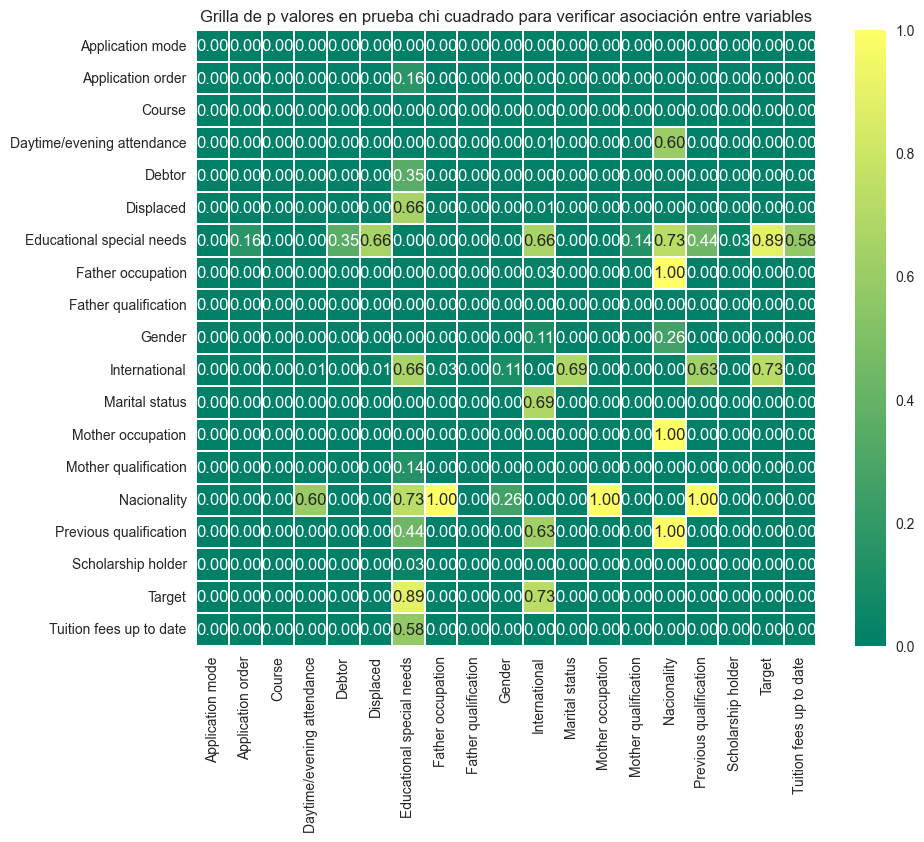

In [12]:
grilla_asociacion, grilla_asociacion2 = asociacion(train)

### - Vemos en su mayoria los p-value son menores al alpha de 10% por lo tanto en la mayoria de variables se observa una buena asociacion de las mismas, a excepcion de por ejemplo Mother's ocupation y Nacionality, y asi mismo Father's ocupation y Nacionality con un p-valor de 1 que son los valores mas grandes observados en la grilla.

# - INGENIERIA DE VARIABLES

## Variables al cuadrado

In [13]:
def prueba_kr(x):
  if x<=0.10:
    return 1
  else:
    return 0

def criterion_(train,columns):
  for k in columns:
    train[k] = train[k].map(prueba_kr)
  train["criterio"] = np.sum(train.get(columns),axis=1)
  train["criterio"] = train.apply(lambda row: 1 if row["criterio"]==3 else 0,axis = 1)
  return train

In [14]:
train["Target"].unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

In [15]:
base_cuadrado = train.get(cuantitativas).copy()
base_cuadrado["Target"] = train["Target"].copy()

var_names2, pvalue1 = [], []

for k in cuantitativas:
    base_cuadrado[k+"_2"] = base_cuadrado[k] ** 2
    # Prueba de Kruskal sin logaritmo
    mue1 = base_cuadrado.loc[base_cuadrado["Target"]=="Graduate",k+"_2"].to_numpy()
    mue2 = base_cuadrado.loc[base_cuadrado["Target"]=="Dropout",k+"_2"].to_numpy()
    mue3 = base_cuadrado.loc[base_cuadrado["Target"]=="Enrolled",k+"_2"].to_numpy()

    p1 = stats.kruskal(mue1,mue2,mue3)[1]

    var_names2.append(k+"_2")
    pvalue1.append(np.round(p1,2))


In [16]:
pcuadrado1 = pd.DataFrame({'Variable2':var_names2,'p value':pvalue1})
pcuadrado1["criterio"] = pcuadrado1.apply(lambda row: 1 if row["p value"]<=0.10 else 0,axis = 1)
pcuadrado1.head(5)

,Variable2,p value,criterio
0,Previous qualification (grade)_2,0.0,1
1,Admission grade_2,0.0,1
2,Age at enrollment_2,0.0,1
3,Curricular units 1st sem (credited)_2,0.0,1
4,Curricular units 1st sem (enrolled)_2,0.0,1


### INTERACCIONES CUANTITATIVAS

In [17]:
lista_inter = list(combinations(cuantitativas,2))
base_interacciones = train.get(cuantitativas).copy()
var_interaccion, pv1 = [], []
base_interacciones["Target"] = train["Target"].copy()

for k in lista_inter:
    base_interacciones[k[0]+"__"+k[1]] = base_interacciones[k[0]] * base_interacciones[k[1]]

    mue1 = base_interacciones.loc[base_interacciones["Target"]=="Graduate",k[0]+"__"+k[1]].to_numpy()
    mue2 = base_interacciones.loc[base_interacciones["Target"]=="Dropout",k[0]+"__"+k[1]].to_numpy()
    mue3 = base_interacciones.loc[base_interacciones["Target"]=="Enrolled",k[0]+"__"+k[1]].to_numpy()

    p1 = stats.kruskal(mue1,mue2,mue3)[1]

    var_interaccion.append(k[0]+"__"+k[1])
    pv1.append(np.round(p1,2))

In [18]:
pxy = pd.DataFrame({'Variable':var_interaccion,'p value':pv1})
pxy["criterio"] = pxy.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
pxy.head(10)

,Variable,p value,criterio
0,Previous qualification (grade)__Admission grade,0.0,1
1,Previous qualification (grade)__Age at enrollment,0.0,1
2,Previous qualification (grade)__Curricular uni...,0.0,1
3,Previous qualification (grade)__Curricular uni...,0.0,1
4,Previous qualification (grade)__Curricular uni...,0.0,1
5,Previous qualification (grade)__Curricular uni...,0.0,1
6,Previous qualification (grade)__Curricular uni...,0.0,1
7,Previous qualification (grade)__Curricular uni...,0.0,1
8,Previous qualification (grade)__Curricular uni...,0.0,1
9,Previous qualification (grade)__Curricular uni...,0.0,1


## Razones

In [19]:
raz1 = [(x,y) for x in cuantitativas for y in cuantitativas]
base_razones1 = train.get(cuantitativas).copy()
base_razones1["Target"] = train["Target"].copy()

var_nm, pval = [], []
for j in raz1:
    if j[0]!=j[1]:
        base_razones1[j[0]+"__coc__"+j[1]] = base_razones1[j[0]] / (base_razones1[j[1]]+0.01)

        mue1 = base_razones1.loc[base_razones1["Target"]=="Graduate",j[0]+"__coc__"+j[1]].to_numpy()
        mue2 = base_razones1.loc[base_razones1["Target"]=="Dropout",j[0]+"__coc__"+j[1]].to_numpy()
        mue3 = base_razones1.loc[base_razones1["Target"]=="Enrolled",j[0]+"__coc__"+j[1]].to_numpy()
        p1 = stats.kruskal(mue1,mue2,mue3)[1]
        
        var_nm.append(j[0]+"__coc__"+j[1])
        pval.append(np.round(p1,2))

In [20]:
prazones = pd.DataFrame({'Variable':var_nm,'p value':pval})
prazones["criterio"] = prazones.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
prazones.head(10)

,Variable,p value,criterio
0,Previous qualification (grade)__coc__Admission...,0.0,1
1,Previous qualification (grade)__coc__Age at en...,0.0,1
2,Previous qualification (grade)__coc__Curricula...,0.0,1
3,Previous qualification (grade)__coc__Curricula...,0.0,1
4,Previous qualification (grade)__coc__Curricula...,0.0,1
5,Previous qualification (grade)__coc__Curricula...,0.0,1
6,Previous qualification (grade)__coc__Curricula...,0.0,1
7,Previous qualification (grade)__coc__Curricula...,0.0,1
8,Previous qualification (grade)__coc__Curricula...,0.0,1
9,Previous qualification (grade)__coc__Curricula...,0.0,1


## Interacciones categóricas

In [21]:
categoricas = list(formato_train.loc[formato_train["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["id","Target"]]

def nombre_(x):
  return "C"+str(x)

In [22]:
cb = list(combinations(categoricas,2))
p_value, modalidades, nombre_var = [], [], []

base2 = train.get(categoricas).copy()
for k in base2.columns:
  base2[k] = base2[k].map(nombre_)

base2["Target"] = train["Target"].copy()

for k in range(len(cb)):
    base2[cb[k][0]] = base2[cb[k][0]]
    base2[cb[k][1]] = base2[cb[k][1]]

    base2[cb[k][0]+"__"+cb[k][1]] = base2[cb[k][0]] + "__" + base2[cb[k][1]]

    c1 = pd.DataFrame(pd.crosstab(base2["Target"],base2[cb[k][0]+"__"+cb[k][1]]))
    pv = stats.chi2_contingency(c1)[1]

    mod_ = len(base2[cb[k][0]+"__"+cb[k][1]].unique())

    nombre_var.append(cb[k][0]+"__"+cb[k][1])
    modalidades.append(mod_)
    p_value.append(pv)

In [23]:
pc = pd.DataFrame({'Variable':nombre_var,'Num Modalidades':modalidades,'p value':p_value})
pc.loc[(pc["p value"]<=0.10) & (pc["Num Modalidades"]<=8),].sort_values(["p value"],ascending=True).head()

,Variable,Num Modalidades,p value
68,Daytime/evening attendance__Displaced,4,0.0
150,Gender__Scholarship holder,4,0.0
149,Tuition fees up to date__International,4,0.0
148,Tuition fees up to date__Scholarship holder,4,0.0
147,Tuition fees up to date__Gender,4,0.0


## Dummies categóricas más significativas (p value <= 0.10 y bajo número de modalidades)

In [24]:
def indicadora(x):
  if x==True:
    return 1
  else:
    return 0

seleccion1 = list(pc.loc[(pc["p value"]<=0.10) & (pc["Num Modalidades"]<=8),"Variable"])
sel1 = base2.get(seleccion1)

contador = 0
for k in sel1:
    if contador==0:
        lb1 = pd.get_dummies(sel1[k],drop_first=True)
        lb1.columns = [k + "_" + x for x in lb1.columns]
    else:
        lb2 = pd.get_dummies(sel1[k],drop_first=True)
        lb2.columns = [k + "_" + x for x in lb2.columns]
        lb1 = pd.concat([lb1,lb2],axis=1)
    contador = contador + 1

for k in lb1.columns:
  lb1[k] = lb1[k].map(indicadora)

lb1["Target"] = train["Target"].copy()
lb1.head(3)

,Daytime/evening attendance__Displaced_C0__C1,Daytime/evening attendance__Displaced_C1__C0,Daytime/evening attendance__Displaced_C1__C1,Daytime/evening attendance__Educational special needs_C0__C1,Daytime/evening attendance__Educational special needs_C1__C0,Daytime/evening attendance__Educational special needs_C1__C1,Daytime/evening attendance__Debtor_C0__C1,Daytime/evening attendance__Debtor_C1__C0,Daytime/evening attendance__Debtor_C1__C1,Daytime/evening attendance__Tuition fees up to date_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,Graduate
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Dropout
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,Dropout


## Interacción cuantitativa vs categórica

In [25]:
cat_cuanti = [(x,y) for x in cuantitativas for y in categoricas]
cat_cuanti[0]

('Previous qualification (grade)', 'Marital status')

In [26]:
v1, v2, pvalores_min, pvalores_max  = [], [], [], []

for j in cat_cuanti:
    k1 = j[0]
    k2 = j[1]

    g1 = pd.get_dummies(train[k2])
    lt1 = list(g1.columns)

    for k in lt1:
        g1[k] = g1[k] * train[k1]

    g1["Target"] = train["Target"].copy()

    pvalues_c = []
    for y in lt1:
        mue1 = g1.loc[g1["Target"]=="Graduate",y].to_numpy()
        mue2 = g1.loc[g1["Target"]=="Dropout",y].to_numpy()
        mue3 = g1.loc[g1["Target"]=="Enrolled",y].to_numpy()

        try:
          pval = (stats.kruskal(mue1,mue2,mue3)[1]<=0.10)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0
        pvalues_c.append(pval)

    min_ = np.min(pvalues_c) 
    max_ = np.max(pvalues_c) 
    v1.append(k1) 
    v2.append(k2) 
    pvalores_min.append(np.round(min_,2))
    pvalores_max.append(np.round(max_,2))

In [27]:
pc2 = pd.DataFrame({'Cuantitativa':v1,'Categórica':v2,'p value':pvalores_min, 'p value max':pvalores_max})
pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),]

,Cuantitativa,Categórica,p value,p value max
4,Previous qualification (grade),Daytime/evening attendance,1,1
11,Previous qualification (grade),Displaced,1,1
13,Previous qualification (grade),Debtor,1,1
14,Previous qualification (grade),Tuition fees up to date,1,1
15,Previous qualification (grade),Gender,1,1
...,...,...,...,...
318,GDP,Educational special needs,1,1
319,GDP,Debtor,1,1
320,GDP,Tuition fees up to date,1,1
321,GDP,Gender,1,1


## Base de Feature Enginnering

In [28]:
v1 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Cuantitativa"])
v2 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Categórica"])

In [29]:
for j in range(len(v1)):

    if j==0:
        g1 = pd.get_dummies(train[v2[j]],drop_first=True)
        lt1 = list(g1.columns)
        for k in lt1:
            g1[k] = g1[k] * train[v1[j]]
        g1.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
    else:
        g2 = pd.get_dummies(train[v2[j]],drop_first=True)
        lt1 = list(g2.columns)
        for k in lt1:
            g2[k] = g2[k] * train[v1[j]]
        g2.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
        g1 = pd.concat([g1,g2],axis=1)

g1["Target"] = train["Target"].copy()
g1.head(5)

,Previous qualification (grade)_Daytime/evening attendance_1,Previous qualification (grade)_Displaced_1,Previous qualification (grade)_Debtor_1,Previous qualification (grade)_Tuition fees up to date_1,Previous qualification (grade)_Gender_1,Previous qualification (grade)_Scholarship holder_1,Admission grade_Daytime/evening attendance_1,Admission grade_Displaced_1,Admission grade_Debtor_1,Admission grade_Tuition fees up to date_1,...,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Daytime/evening attendance_1,GDP_Displaced_1,GDP_Educational special needs_1,GDP_Debtor_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,Target
0,126.0,0.0,0.0,126.0,0.0,126.0,122.6,0.0,0.0,122.6,...,0.0,0.6,2.02,0.00,0.0,0.0,2.02,0.00,2.02,Graduate
1,125.0,125.0,0.0,125.0,0.0,0.0,119.8,119.8,0.0,119.8,...,0.0,0.0,2.02,2.02,0.0,0.0,2.02,0.00,0.00,Dropout
2,137.0,0.0,0.0,137.0,137.0,0.0,144.7,0.0,0.0,144.7,...,0.3,0.0,-0.92,-0.00,-0.0,-0.0,-0.92,-0.92,-0.00,Dropout
3,131.0,131.0,0.0,131.0,0.0,131.0,126.1,126.1,0.0,126.1,...,0.0,0.6,2.02,2.02,0.0,0.0,2.02,0.00,2.02,Enrolled
4,132.0,132.0,0.0,132.0,0.0,0.0,120.1,120.1,0.0,120.1,...,0.0,0.0,0.32,0.32,0.0,0.0,0.32,0.00,0.00,Graduate


## Selección de variables con XGBOOST

### variables al cuadrado

In [30]:
pcuadrado1.head()

,Variable2,p value,criterio
0,Previous qualification (grade)_2,0.0,1
1,Admission grade_2,0.0,1
2,Age at enrollment_2,0.0,1
3,Curricular units 1st sem (credited)_2,0.0,1
4,Curricular units 1st sem (enrolled)_2,0.0,1


In [31]:
def indicadora1(x):
  if x=="Graduate":
    return 0
  elif x=="Enrolled":
    return 1
  else:
    return 2

In [32]:

var_cuad = list(pcuadrado1["Variable2"])
base_modelo1 = base_cuadrado.get(var_cuad+["Target"])
base_modelo1["Target"] = base_modelo1["Target"].map(indicadora1)
base_modelo1.head()

,Previous qualification (grade)_2,Admission grade_2,Age at enrollment_2,Curricular units 1st sem (credited)_2,Curricular units 1st sem (enrolled)_2,Curricular units 1st sem (evaluations)_2,Curricular units 1st sem (approved)_2,Curricular units 1st sem (grade)_2,Curricular units 1st sem (without evaluations)_2,Curricular units 2nd sem (credited)_2,Curricular units 2nd sem (enrolled)_2,Curricular units 2nd sem (evaluations)_2,Curricular units 2nd sem (approved)_2,Curricular units 2nd sem (grade)_2,Curricular units 2nd sem (without evaluations)_2,Unemployment rate_2,Inflation rate_2,GDP_2,Target
0,15876.0,15030.76,324,0,36,36,36,210.250000,0,0,36,49,36,154.469388,0,123.21,0.36,4.0804,0
1,15625.0,14352.04,324,0,36,64,16,134.560000,0,0,36,81,0,0.000000,0,123.21,0.36,4.0804,2
2,18769.0,20938.09,324,0,36,0,0,0.000000,0,0,36,0,0,0.000000,0,262.44,0.09,0.8464,2
3,17161.0,15901.21,324,0,49,81,49,158.539577,0,0,64,121,49,164.352400,0,123.21,0.36,4.0804,1
4,17424.0,14424.01,324,0,49,144,36,167.271111,0,0,49,144,36,167.271111,0,57.76,6.76,0.1024,0


In [33]:
cov = list(base_modelo1.columns)
cov = [x for x in cov if x not in ["Target"]]

X1 = base_modelo1.get(cov)
y1 = base_modelo1.get(["Target"])

modelo1 = XGBClassifier()
modelo1 = modelo1.fit(X1,y1)

importancias = modelo1.feature_importances_
imp1 = pd.DataFrame({'Variable':X1.columns,'Importancia':importancias})
imp1["Importancia"] = imp1["Importancia"] * 100 / np.sum(imp1["Importancia"])
imp1 = imp1.sort_values(["Importancia"],ascending=False)
imp1.index = range(imp1.shape[0])
imp1.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)_2,70.808594
1,Curricular units 2nd sem (enrolled)_2,4.378177
2,Curricular units 2nd sem (evaluations)_2,4.194392
3,Curricular units 1st sem (approved)_2,2.990435
4,Curricular units 1st sem (enrolled)_2,2.726732
5,Curricular units 2nd sem (grade)_2,2.613068
6,Curricular units 1st sem (evaluations)_2,1.963291
7,Age at enrollment_2,1.516176
8,Curricular units 2nd sem (credited)_2,1.128750
9,Curricular units 1st sem (grade)_2,1.089914


## Interacciones cuantitativas

In [34]:
pxy.head()

,Variable,p value,criterio
0,Previous qualification (grade)__Admission grade,0.0,1
1,Previous qualification (grade)__Age at enrollment,0.0,1
2,Previous qualification (grade)__Curricular uni...,0.0,1
3,Previous qualification (grade)__Curricular uni...,0.0,1
4,Previous qualification (grade)__Curricular uni...,0.0,1


In [35]:
var_int = list(pxy["Variable"])
base_modelo2 = base_interacciones.get(var_int+["Target"])
base_modelo2["Target"] = base_modelo2["Target"].map(indicadora1)
base_modelo2.head()

,Previous qualification (grade)__Admission grade,Previous qualification (grade)__Age at enrollment,Previous qualification (grade)__Curricular units 1st sem (credited),Previous qualification (grade)__Curricular units 1st sem (enrolled),Previous qualification (grade)__Curricular units 1st sem (evaluations),Previous qualification (grade)__Curricular units 1st sem (approved),Previous qualification (grade)__Curricular units 1st sem (grade),Previous qualification (grade)__Curricular units 1st sem (without evaluations),Previous qualification (grade)__Curricular units 2nd sem (credited),Previous qualification (grade)__Curricular units 2nd sem (enrolled),...,Curricular units 2nd sem (grade)__Unemployment rate,Curricular units 2nd sem (grade)__Inflation rate,Curricular units 2nd sem (grade)__GDP,Curricular units 2nd sem (without evaluations)__Unemployment rate,Curricular units 2nd sem (without evaluations)__Inflation rate,Curricular units 2nd sem (without evaluations)__GDP,Unemployment rate__Inflation rate,Unemployment rate__GDP,Inflation rate__GDP,Target
0,15447.6,2268.0,0.0,756.0,756.0,756.0,1827.00000,0.0,0.0,756.0,...,137.957143,7.457143,25.105714,0.0,0.0,0.0,6.66,22.422,1.212,0
1,14975.0,2250.0,0.0,750.0,1000.0,500.0,1450.00000,0.0,0.0,750.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.66,22.422,1.212,2
2,19823.9,2466.0,0.0,822.0,0.0,0.0,0.00000,0.0,0.0,822.0,...,0.000000,0.000000,-0.000000,0.0,0.0,-0.0,4.86,-14.904,-0.276,2
3,16519.1,2358.0,0.0,917.0,1179.0,917.0,1649.45375,0.0,0.0,1048.0,...,142.302000,7.692000,25.896400,0.0,0.0,0.0,6.66,22.422,1.212,1
4,15853.2,2376.0,0.0,924.0,1584.0,792.0,1707.20000,0.0,0.0,924.0,...,98.293333,33.626667,4.138667,0.0,0.0,0.0,19.76,2.432,0.832,0


In [36]:
cov = list(base_modelo2.columns)
cov = [x for x in cov if x not in ["Target"]]

X2 = base_modelo2.get(cov)
y2 = base_modelo2.get(["Target"])

modelo2 = XGBClassifier()
modelo2 = modelo2.fit(X2,y2)

importancias = modelo2.feature_importances_
imp2 = pd.DataFrame({'Variable':X2.columns,'Importancia':importancias})
imp2["Importancia"] = imp2["Importancia"] * 100 / np.sum(imp2["Importancia"])
imp2 = imp2.sort_values(["Importancia"],ascending=False)
imp2.index = range(imp2.shape[0])
imp2.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)__Curricula...,19.316521
1,Admission grade__Curricular units 2nd sem (app...,14.658401
2,Curricular units 1st sem (approved)__Curricula...,7.187466
3,Curricular units 1st sem (grade)__Curricular u...,6.013840
4,Curricular units 1st sem (evaluations)__Curric...,4.931830
5,Age at enrollment__Curricular units 2nd sem (e...,3.025591
6,Curricular units 1st sem (enrolled)__Curricula...,2.240528
7,Curricular units 2nd sem (evaluations)__Curric...,1.637805
8,Previous qualification (grade)__Curricular uni...,1.574711
9,Curricular units 2nd sem (evaluations)__Curric...,1.260020


### Razones

In [37]:
prazones.head()

,Variable,p value,criterio
0,Previous qualification (grade)__coc__Admission...,0.0,1
1,Previous qualification (grade)__coc__Age at en...,0.0,1
2,Previous qualification (grade)__coc__Curricula...,0.0,1
3,Previous qualification (grade)__coc__Curricula...,0.0,1
4,Previous qualification (grade)__coc__Curricula...,0.0,1


In [38]:
var_raz = list(prazones["Variable"])
base_modelo3 = base_razones1.get(var_raz+["Target"])
base_modelo3["Target"] = base_modelo3["Target"].map(indicadora1)
base_modelo3.head()

,Previous qualification (grade)__coc__Admission grade,Previous qualification (grade)__coc__Age at enrollment,Previous qualification (grade)__coc__Curricular units 1st sem (credited),Previous qualification (grade)__coc__Curricular units 1st sem (enrolled),Previous qualification (grade)__coc__Curricular units 1st sem (evaluations),Previous qualification (grade)__coc__Curricular units 1st sem (approved),Previous qualification (grade)__coc__Curricular units 1st sem (grade),Previous qualification (grade)__coc__Curricular units 1st sem (without evaluations),Previous qualification (grade)__coc__Curricular units 2nd sem (credited),Previous qualification (grade)__coc__Curricular units 2nd sem (enrolled),...,GDP__coc__Curricular units 1st sem (without evaluations),GDP__coc__Curricular units 2nd sem (credited),GDP__coc__Curricular units 2nd sem (enrolled),GDP__coc__Curricular units 2nd sem (evaluations),GDP__coc__Curricular units 2nd sem (approved),GDP__coc__Curricular units 2nd sem (grade),GDP__coc__Curricular units 2nd sem (without evaluations),GDP__coc__Unemployment rate,GDP__coc__Inflation rate,Target
0,1.027649,6.996113,12600.0,20.965058,20.965058,20.965058,8.683666,12600.0,12600.0,20.965058,...,202.0,202.0,0.336106,0.288160,0.336106,0.162398,202.0,0.181818,3.311475,0
1,1.043319,6.940589,12500.0,20.798669,15.605493,31.172070,10.766581,12500.0,12500.0,20.798669,...,202.0,202.0,0.336106,0.224195,202.000000,202.000000,202.0,0.181818,3.311475,2
2,0.946721,7.606885,13700.0,22.795341,13700.000000,13700.000000,13700.000000,13700.0,13700.0,22.795341,...,-92.0,-92.0,-0.153078,-92.000000,-92.000000,-92.000000,-92.0,-0.056755,-2.967742,2
3,1.038776,7.273737,13100.0,18.687589,14.539401,18.687589,10.395794,13100.0,13100.0,16.354557,...,202.0,202.0,0.252185,0.183470,0.288160,0.157443,202.0,0.181818,3.311475,1
4,1.098993,7.329262,13200.0,18.830243,10.990841,21.963394,10.198300,13200.0,13200.0,18.830243,...,32.0,32.0,0.045649,0.026644,0.053245,0.024723,32.0,0.042050,0.122605,0


In [39]:
cov = list(base_modelo3.columns)
cov = [x for x in cov if x not in ["Target"]]

X3 = base_modelo3.get(cov)
y3 = base_modelo3.get(["Target"])

modelo3 = XGBClassifier()
modelo3 = modelo3.fit(X3,y3)

importancias = modelo3.feature_importances_
imp3 = pd.DataFrame({'Variable':X3.columns,'Importancia':importancias})
imp3["Importancia"] = imp3["Importancia"] * 100 / np.sum(imp3["Importancia"])
imp3 = imp3.sort_values(["Importancia"],ascending=False)
imp3.index = range(imp3.shape[0])
imp3.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)__coc__Curr...,24.569319
1,Curricular units 2nd sem (approved)__coc__Curr...,20.368172
2,Curricular units 2nd sem (approved)__coc__Age ...,9.885358
3,Age at enrollment__coc__Curricular units 2nd s...,5.625616
4,Curricular units 2nd sem (evaluations)__coc__C...,5.341390
5,Curricular units 2nd sem (enrolled)__coc__Curr...,2.519095
6,Curricular units 2nd sem (grade)__coc__Curricu...,2.074363
7,Curricular units 1st sem (approved)__coc__Curr...,1.556366
8,Curricular units 1st sem (enrolled)__coc__Curr...,1.227763
9,Curricular units 1st sem (approved)__coc__Curr...,0.910344


## Interacciones categóricas

In [40]:
pc.head()

,Variable,Num Modalidades,p value
0,Marital status__Application mode,57,0.0
1,Marital status__Application order,30,0.0
2,Marital status__Course,85,0.0
3,Marital status__Daytime/evening attendance,12,0.0
4,Marital status__Previous qualification,66,0.0


In [41]:
lb1["Target"] = lb1["Target"].map(indicadora1)
lb1.head()

,Daytime/evening attendance__Displaced_C0__C1,Daytime/evening attendance__Displaced_C1__C0,Daytime/evening attendance__Displaced_C1__C1,Daytime/evening attendance__Educational special needs_C0__C1,Daytime/evening attendance__Educational special needs_C1__C0,Daytime/evening attendance__Educational special needs_C1__C1,Daytime/evening attendance__Debtor_C0__C1,Daytime/evening attendance__Debtor_C1__C0,Daytime/evening attendance__Debtor_C1__C1,Daytime/evening attendance__Tuition fees up to date_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,2
3,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
cov = list(lb1.columns)
cov = [x for x in cov if x not in ["Target"]]

X4 = lb1.get(cov)
y4 = lb1.get(["Target"])

modelo4 = XGBClassifier()
modelo4 = modelo4.fit(X4,y4)

importancias = modelo4.feature_importances_
imp4 = pd.DataFrame({'Variable':X4.columns,'Importancia':importancias})
imp4["Importancia"] = imp4["Importancia"] * 100 / np.sum(imp4["Importancia"])
imp4 = imp4.sort_values(["Importancia"],ascending=False)
imp4.index = range(imp4.shape[0])
imp4.head(5)

,Variable,Importancia
0,Tuition fees up to date__Scholarship holder_C1...,49.476303
1,Educational special needs__Tuition fees up to ...,19.045549
2,Gender__Scholarship holder_C1__C0,6.896832
3,Tuition fees up to date__Scholarship holder_C1...,5.680700
4,Debtor__Scholarship holder_C0__C1,5.352096


## Interacción cuantitativa - categórica

In [43]:
g1["Target"] = g1["Target"].map(indicadora1)
g1.head()

,Previous qualification (grade)_Daytime/evening attendance_1,Previous qualification (grade)_Displaced_1,Previous qualification (grade)_Debtor_1,Previous qualification (grade)_Tuition fees up to date_1,Previous qualification (grade)_Gender_1,Previous qualification (grade)_Scholarship holder_1,Admission grade_Daytime/evening attendance_1,Admission grade_Displaced_1,Admission grade_Debtor_1,Admission grade_Tuition fees up to date_1,...,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Daytime/evening attendance_1,GDP_Displaced_1,GDP_Educational special needs_1,GDP_Debtor_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,Target
0,126.0,0.0,0.0,126.0,0.0,126.0,122.6,0.0,0.0,122.6,...,0.0,0.6,2.02,0.00,0.0,0.0,2.02,0.00,2.02,0
1,125.0,125.0,0.0,125.0,0.0,0.0,119.8,119.8,0.0,119.8,...,0.0,0.0,2.02,2.02,0.0,0.0,2.02,0.00,0.00,2
2,137.0,0.0,0.0,137.0,137.0,0.0,144.7,0.0,0.0,144.7,...,0.3,0.0,-0.92,-0.00,-0.0,-0.0,-0.92,-0.92,-0.00,2
3,131.0,131.0,0.0,131.0,0.0,131.0,126.1,126.1,0.0,126.1,...,0.0,0.6,2.02,2.02,0.0,0.0,2.02,0.00,2.02,1
4,132.0,132.0,0.0,132.0,0.0,0.0,120.1,120.1,0.0,120.1,...,0.0,0.0,0.32,0.32,0.0,0.0,0.32,0.00,0.00,0


In [44]:
cov = list(g1.columns)
cov = [x for x in cov if x not in ["Target"]]

X5 = g1.get(cov)
y5 = g1.get(["Target"])

modelo5 = XGBClassifier()
modelo5 = modelo5.fit(X5,y5)

importancias = modelo5.feature_importances_
imp5 = pd.DataFrame({'Variable':X5.columns,'Importancia':importancias})
imp5["Importancia"] = imp5["Importancia"] * 100 / np.sum(imp5["Importancia"])
imp5 = imp5.sort_values(["Importancia"],ascending=False)
imp5.index = range(imp5.shape[0])
imp5.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)_Tuition fe...,49.155079
1,Curricular units 2nd sem (evaluations)_Tuition...,3.849860
2,Curricular units 1st sem (approved)_Tuition fe...,2.467927
3,Curricular units 1st sem (evaluations)_Tuition...,2.255300
4,Curricular units 1st sem (enrolled)_Scholarshi...,2.024856
5,Unemployment rate_Scholarship holder_1,1.839798
6,Curricular units 2nd sem (enrolled)_Tuition fe...,1.761177
7,Curricular units 2nd sem (grade)_Tuition fees ...,1.378479
8,Curricular units 1st sem (approved)_Scholarshi...,1.291412
9,Curricular units 2nd sem (approved)_Educationa...,0.898464


## Variables más importantes por XGBOOST en cada caso

In [45]:
c2 = list(imp1.iloc[0:3,0]) # Variables al cuadrado
c2

['Curricular units 2nd sem (approved)_2',
 'Curricular units 2nd sem (enrolled)_2',
 'Curricular units 2nd sem (evaluations)_2']

In [46]:
cxy = list(imp2.iloc[0:3,0]) # Interacciones cuantitativas
cxy

['Curricular units 2nd sem (approved)__Curricular units 2nd sem (grade)',
 'Admission grade__Curricular units 2nd sem (approved)',
 'Curricular units 1st sem (approved)__Curricular units 2nd sem (approved)']

In [47]:
razxy = list(imp3.iloc[0:3,0]) # Razones
razxy

['Curricular units 2nd sem (approved)__coc__Curricular units 1st sem (enrolled)',
 'Curricular units 2nd sem (approved)__coc__Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (approved)__coc__Age at enrollment']

In [48]:
catxy = list(imp4.iloc[0:3,0]) # Interacciones categóricas
catxy

['Tuition fees up to date__Scholarship holder_C1__C1',
 'Educational special needs__Tuition fees up to date_C0__C1',
 'Gender__Scholarship holder_C1__C0']

In [49]:
cuactxy = list(imp5.iloc[0:3,0]) # Interacción cuantitativa y categórica
cuactxy

['Curricular units 2nd sem (approved)_Tuition fees up to date_1',
 'Curricular units 2nd sem (evaluations)_Tuition fees up to date_1',
 'Curricular units 1st sem (approved)_Tuition fees up to date_1']

## Preparación de datos

In [50]:
# Variables cuantitativas (Activar D1)
D1 = train.get(cuantitativas).copy()

# Variables categóricas
D2 = train.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = train.copy()
result4 = [re.search(r'(.+?)_(.+?)_1', item).groups() for item in cuactxy]
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+"_"+col1+"_"+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+"_"+col1+"_"+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
  contador = contador + 1

In [51]:
cuadrado

['Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)']

## Base modelo

In [52]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo = pd.concat([B1,D51],axis=1)
base_modelo["Target"] = train["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(indicadora1)
base_modelo.head(3)

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),...,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,Target
0,126.0,122.6,18,0,6,6,6,14.5,0,0,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,7,6,0
1,125.0,119.8,18,0,6,8,4,11.6,0,0,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,0,9,4,2
2,137.0,144.7,18,0,6,0,0,0.0,0,0,...,C1,C0,C0,C1_C0,C0_C1,C1_C0,0,0,0,2


## AUTOML

In [53]:
column_types = base_modelo.dtypes
print(column_types)

Previous qualification (grade)                                                   float64
Admission grade                                                                  float64
Age at enrollment                                                                  int64
Curricular units 1st sem (credited)                                                int64
Curricular units 1st sem (enrolled)                                                int64
Curricular units 1st sem (evaluations)                                             int64
Curricular units 1st sem (approved)                                                int64
Curricular units 1st sem (grade)                                                 float64
Curricular units 1st sem (without evaluations)                                     int64
Curricular units 2nd sem (credited)                                                int64
Curricular units 2nd sem (enrolled)                                                int64
Curricular units 2nd 

In [54]:
base_modelo.head()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),...,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,Target
0,126.0,122.6,18,0,6,6,6,14.500000,0,0,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,7,6,0
1,125.0,119.8,18,0,6,8,4,11.600000,0,0,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,0,9,4,2
2,137.0,144.7,18,0,6,0,0,0.000000,0,0,...,C1,C0,C0,C1_C0,C0_C1,C1_C0,0,0,0,2
3,131.0,126.1,18,0,7,9,7,12.591250,0,0,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,7,11,7,1
4,132.0,120.1,18,0,7,12,6,12.933333,0,0,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,12,6,0


In [55]:
formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable","Formato"]
cuantitativas_bm = list(formatos.loc[formatos["Formato"]!="object",]["Variable"])
categoricas_bm = list(formatos.loc[formatos["Formato"]=="object",]["Variable"])
cuantitativas_bm = [x for x in cuantitativas_bm if x not in ["Target"]]
categoricas_bm = [x for x in categoricas_bm if x not in ["Target"]]

In [56]:
cuantitativas_bm

['Previous qualification (grade)',
 'Admission grade',
 'Age at enrollment',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'Curricular units 2nd sem (approved)_2',
 'Curricular units 2nd sem (enrolled)_2',
 'Curricular units 2nd sem (evaluations)_2',
 'Curricular units 2nd sem (approved)__Curricular units 2nd sem (grade)',
 'Admission grade__Curricular units 2nd sem (approved)',
 'Curricular units 1st sem (approved)__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (approve

In [57]:
categoricas_bm

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nacionality',
 'Mother qualification',
 'Father qualification',
 'Mother occupation',
 'Father occupation',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International',
 'Tuition fees up to date__Scholarship holder',
 'Educational special needs__Tuition fees up to date',
 'Gender__Scholarship holder']

In [58]:
exp_clf101 = setup(data=base_modelo,
target='Target',
session_id=123,
train_size=0.7,
numeric_features = cuantitativas_bm,
categorical_features = categoricas_bm,
fix_imbalance=False)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 52)"
4,Transformed data shape,"(76518, 148)"
5,Transformed train set shape,"(53562, 148)"
6,Transformed test set shape,"(22956, 148)"
7,Numeric features,30
8,Categorical features,21
9,Preprocess,True


In [59]:
%%time
dt = create_model('lightgbm')  
#dt2 = create_model('xgboost')
#dt3 = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8268,0.9382,0.8268,0.8249,0.8246,0.7208,0.7221
1,0.8311,0.9452,0.8311,0.8319,0.8302,0.7284,0.7298
2,0.8336,0.9451,0.8336,0.8322,0.8320,0.7323,0.7334
3,0.8316,0.9446,0.8316,0.8310,0.8303,0.7291,0.7303
4,0.8396,0.9450,0.8396,0.8397,0.8383,0.7420,0.7434
5,0.8379,0.9462,0.8379,0.8354,0.8356,0.7388,0.7400
6,0.8297,0.9440,0.8297,0.8281,0.8276,0.7255,0.7270
7,0.8299,0.9414,0.8299,0.8280,0.8277,0.7257,0.7271
8,0.8251,0.9436,0.8251,0.8246,0.8236,0.7184,0.7198


CPU times: total: 8.56 s
Wall time: 51 s


In [60]:
from pycaret.classification import *
hyperparameters = dt.get_params()
hyperparameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Continuar optimización

In [61]:
###### %%time

param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}

tuned_dt = tune_model(dt, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)
#tuned_dt2 = tune_model(dt2, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)
#tuned_dt3 = tune_model(dt3, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8288,0.9422,0.8288,0.8276,0.8272,0.7244,0.7256
1,0.8341,0.9449,0.8341,0.8328,0.8326,0.7332,0.7342
2,0.8360,0.9442,0.8360,0.8339,0.8338,0.7357,0.7370
3,0.8298,0.9425,0.8298,0.8269,0.8271,0.7253,0.7267
4,0.8304,0.9436,0.8304,0.8303,0.8288,0.7267,0.7284
Mean,0.8318,0.9435,0.8318,0.8303,0.8299,0.7291,0.7304
Std,0.0027,0.0010,0.0027,0.0028,0.0028,0.0045,0.0044


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [62]:
evaluate_model(tuned_dt)
#evaluate_model(tuned_dt2)
#evaluate_model(tuned_dt3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [63]:
predictions_test = predict_model(tuned_dt)
#predictions_test2 = predict_model(tuned_dt2)
#predictions_test3 = predict_model(tuned_dt3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8319,0.9442,0.8319,0.8309,0.8300,0.7289,0.7305


In [64]:
predictions_train = predict_model(tuned_dt, data=exp_clf101.get_config('X_train'))
#predictions_train2 = predict_model(tuned_dt2, data=exp_clf101.get_config('X_train'))
#predictions_train3 = predict_model(tuned_dt3, data=exp_clf101.get_config('X_train'))

In [65]:
y_train = get_config('y_train')
y_test = get_config('y_test')

#y_train2 = get_config('y_train')
#y_test2 = get_config('y_test')

#y_train3 = get_config('y_train')
#y_test3 = get_config('y_test')

In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(accuracy_score(y_train,predictions_train["prediction_label"]))
print(accuracy_score(y_test,predictions_test["prediction_label"]))

#print(accuracy_score(y_train2,predictions_train2["prediction_label"]))
#print(accuracy_score(y_test2,predictions_test2["prediction_label"]))

#print(accuracy_score(y_train3,predictions_train3["prediction_label"]))
#print(accuracy_score(y_test3,predictions_test3["prediction_label"]))

0.8658937306299243
0.8318522390660393


## Entrenamiento del modelo completo

In [67]:
%%time

final_dt = finalize_model(tuned_dt)
#final_dt2 = finalize_model(tuned_dt2)
#final_dt3 = finalize_model(tuned_dt3)

CPU times: total: 18.7 s
Wall time: 11.2 s


## Predicción nuevos datos

In [68]:
# Variables cuantitativas (Activar D1)
D1 = test.get(cuantitativas).copy()

# Variables categóricas
D2 = test.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = test.copy()
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+"_"+col1+"_"+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+"_"+col1+"_"+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
  contador = contador + 1

In [69]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo2 = pd.concat([B1,D51],axis=1)
base_modelo2.head(3)

#B2 = pd.concat([D1,D4],axis=1)
#base_modelo22 = pd.concat([B2,D51],axis=1)
#base_modelo22.head(3)

#B3 = pd.concat([D1,D4],axis=1)
#base_modelo3 = pd.concat([B3,D51],axis=1)
#base_modelo3.head(3)

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),...,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1
0,141.0,152.1,18,0,7,0,0,0.000000,0,0,...,C0,C0,C0,C0,C0_C0,C0_C0,C0_C0,0,0,0
1,128.0,116.5,19,0,6,7,6,14.857143,0,0,...,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,6,6
2,118.0,114.2,18,0,6,11,6,12.000000,0,0,...,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,5,11,6


In [70]:
df_test = base_modelo2.copy()
column_types = df_test.dtypes
print(column_types)

#df_test2 = base_modelo22.copy()
#column_types = df_test2.dtypes
#print(column_types)

#df_test3 = base_modelo3.copy()
#column_types = df_test3.dtypes
#print(column_types)

Previous qualification (grade)                                                   float64
Admission grade                                                                  float64
Age at enrollment                                                                  int64
Curricular units 1st sem (credited)                                                int64
Curricular units 1st sem (enrolled)                                                int64
Curricular units 1st sem (evaluations)                                             int64
Curricular units 1st sem (approved)                                                int64
Curricular units 1st sem (grade)                                                 float64
Curricular units 1st sem (without evaluations)                                     int64
Curricular units 2nd sem (credited)                                                int64
Curricular units 2nd sem (enrolled)                                                int64
Curricular units 2nd 

In [71]:
predictions = predict_model(final_dt, data=df_test)
#predictions2 = predict_model(final_dt2, data=df_test2)
#predictions3 = predict_model(final_dt3, data=df_test2)

In [72]:
predictions["prediction_label"].value_counts()
#predictions2["prediction_label"].value_counts()
#predictions3["prediction_label"].value_counts()

prediction_label
0    26383
2    15324
1     9305
Name: count, dtype: int64

In [73]:
predictions.head(10)
#predictions2.head(10)
#predictions3.head(10)

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),...,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,prediction_label,prediction_score
0,141.0,152.100006,18,0,7,0,0,0.000000,0,0,...,C0,C0,C0_C0,C0_C0,C0_C0,0,0,0,2,0.9960
1,128.0,116.500000,19,0,6,7,6,14.857142,0,0,...,C0,C0,C1_C0,C0_C1,C0_C0,6,6,6,0,0.9868
2,118.0,114.199997,18,0,6,11,6,12.000000,0,0,...,C1,C0,C1_C1,C0_C1,C0_C1,5,11,6,0,0.7227
3,130.0,130.000000,23,2,6,15,5,11.500000,0,3,...,C1,C0,C1_C1,C0_C1,C0_C1,5,14,5,1,0.4444
4,110.0,106.000000,26,0,6,9,3,11.000000,0,0,...,C0,C0,C1_C0,C0_C1,C0_C0,4,9,3,1,0.6119
5,137.0,127.400002,18,0,6,7,6,15.000000,0,0,...,C0,C0,C1_C0,C0_C1,C0_C0,6,7,6,0,0.9940
6,126.0,118.699997,18,0,6,6,6,12.666667,0,0,...,C0,C0,C1_C0,C0_C1,C0_C0,6,6,6,0,0.9407
7,150.0,150.000000,21,0,6,8,6,12.750000,0,0,...,C0,C0,C1_C0,C0_C1,C0_C0,6,6,6,0,0.9667
8,131.0,132.300003,18,0,6,8,4,10.750000,0,0,...,C1,C0,C0_C1,C0_C0,C1_C1,0,0,0,2,0.7245
9,111.0,109.300003,19,0,6,8,6,12.833333,0,0,...,C0,C0,C1_C0,C0_C1,C1_C0,6,6,6,0,0.9228


In [74]:
test.head(2)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother qualification,Father qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,1,1,9500,1,1,141.0,1,3,1,...,0,0,8,0,0,0.0,0,13.9,-0.3,0.79
1,1,1,1,9238,1,1,128.0,1,1,19,...,0,0,6,6,6,13.5,0,11.1,0.6,2.02


In [75]:
test12 = pd.read_csv(path + "test.csv")
# Create a DataFrame with 'id' and 'Exited' probabilities
result = pd.DataFrame({
    'id': test12["id"],
    'Target': predictions["prediction_label"]
})

#result2 = pd.DataFrame({
#    'id': test12["id"],
#    'Target': predictions2['sc']
#})

#result3 = pd.DataFrame({
 #   'id': test12["id"],
  #  'Target': predictions3['sc']
#})
def indicadora2(x):
  if x==0:
    return "Graduate"
  elif x== 1:
    return "Enrolled"
  else:
    return "Dropout"
result["Target"] = result["Target"].map(indicadora2)
#result2["Target"] = result2["Target"].map(indicadora2)
#result3["Target"] = result3["Target"].map(indicadora2)

result.head(5)
#result2.head(5)
#result3.head(5)

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


In [76]:
result.shape
#result2.shape
#result3.shape

(51012, 2)

In [77]:
# Save the result to a CSV file
result.to_csv(path + 'subbmision_1IA.csv', index=False,sep=",")
#result2.to_csv(path + 'subbmision_2IA.csv', index=False,sep=",")
#result3.to_csv(path + 'subbmision_3IA.csv', index=False,sep=",")

In [78]:
import pickle
with open(path + 'best_model.pkl', 'wb') as model_file:
    pickle.dump(final_dt, model_file)

In [79]:
with open(path + 'best_model.pkl', 'rb') as model_file:
    dt2 = pickle.load(model_file)

In [80]:
base_modelo1.columns

Index(['Previous qualification (grade)_2', 'Admission grade_2',
       'Age at enrollment_2', 'Curricular units 1st sem (credited)_2',
       'Curricular units 1st sem (enrolled)_2',
       'Curricular units 1st sem (evaluations)_2',
       'Curricular units 1st sem (approved)_2',
       'Curricular units 1st sem (grade)_2',
       'Curricular units 1st sem (without evaluations)_2',
       'Curricular units 2nd sem (credited)_2',
       'Curricular units 2nd sem (enrolled)_2',
       'Curricular units 2nd sem (evaluations)_2',
       'Curricular units 2nd sem (approved)_2',
       'Curricular units 2nd sem (grade)_2',
       'Curricular units 2nd sem (without evaluations)_2',
       'Unemployment rate_2', 'Inflation rate_2', 'GDP_2', 'Target'],
      dtype='object')